In [2]:
import numpy as np 
import pandas as pd 
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
import calendar
from statsmodels.tsa.arima.model import ARIMA
# from fbprophet import Prophet
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import Sequential 
from keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from sklearn.metrics import mean_squared_error, mean_squared_log_error
import keras.backend as K
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
import itertools
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from keras import optimizers
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
import tensorflow as tf

2023-10-29 13:31:39.199314: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:

train_csv = pd.read_csv("/Users/nayanarora/Desktop/AIT/Project/code/data/train.csv")
test_csv = pd.read_csv("/Users/nayanarora/Desktop/AIT/Project/code/data/test.csv")
oil_prices_csv = pd.read_csv("/Users/nayanarora/Desktop/AIT/Project/code/data/oil.csv")
holidays_events_csv = pd.read_csv("/Users/nayanarora/Desktop/AIT/Project/code/data/holidays_events.csv")
stores_csv = pd.read_csv("/Users/nayanarora/Desktop/AIT/Project/code/data/stores.csv")
transactions_csv = pd.read_csv("/Users/nayanarora/Desktop/AIT/Project/code/data/transactions.csv")

print ("Training Data Shape: ", train_csv.shape)
print ("Testing Data Shape", test_csv.shape)

train_csv.head()

Training Data Shape:  (3000888, 6)
Testing Data Shape (28512, 5)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
test_csv.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


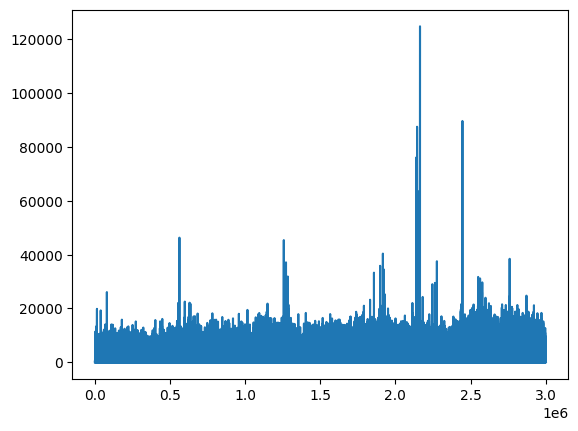

In [5]:
sales_plot = train_csv[["sales"]].values.astype('float32')

plt.plot(sales_plot)
plt.show()

In [6]:
def describe_data(df):
    print("-------------------------------TOP RECORDS-----------------------------")
    print(df.head())
    print("-------------------------------INFO--------------------------------------")
    print(df.info())
    print("-------------------------------Describe----------------------------------")
    print(df.describe())
    print("-------------------------------Attributes-----------------------------------")
    print(df.columns)
    print("-------------------------------Data Types--------------------------------")
    print(df.dtypes)
    print("----------------------------Missing Values-------------------------------")
    print(df.isnull().sum())
    print("----------------------------NULL values----------------------------------")
    print(df.isna().sum())
    print("--------------------------Shape Of Data---------------------------------")
    print(df.shape)

In [7]:

print("\n\n\n=================================Train Data=================================")
describe_data(train_csv)
print("\n\n\n=================================Test data=================================")
describe_data(test_csv)
print("\n\n\n=================================Holidays events=================================")
describe_data(holidays_events_csv)
print("\n\n\n=================================Transaction records=================================")
describe_data(transactions_csv)
print("\n\n\n=================================Stores Information=================================")
describe_data(stores_csv)
print("\n\n\n=================================Oil delivery records=================================")
describe_data(oil_prices_csv)




=================================Train Data=================================
-------------------------------TOP RECORDS-----------------------------
   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0
-------------------------------INFO--------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None
-------------------

##### We now perform a merge for the training and test datasets based on unique id identifiers as below to have one big csv for all influencing attributes together. Performing this tep will enable easier interpratation of all data at once when training different models.

In [8]:
X = train_csv.merge(oil_prices_csv, on = 'date', how='left')
X = X.merge(holidays_events_csv, on = 'date', how='left')
X = X.merge(stores_csv, on = 'store_nbr', how='left')
X = X.merge(transactions_csv, on = ['date', 'store_nbr'], how='left')
X = X.rename(columns = {"type_x" : "holiday_description", "type_y" : "store_type"})

# y = test_csv.merge(oil_prices_csv, on = 'date', how='left')
# y = y.merge(holidays_events_csv, on = 'date', how='left')
# y = y.merge(stores_csv, on = 'store_nbr', how='left')
# y = y.merge(transactions_csv, on = ['date', 'store_nbr'], how='left')
# y = y.rename(columns = {"type_x" : "holiday_description", "type_y" : "store_type"})

X.tail()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday_description,locale,locale_name,description,transferred,city,state,store_type,cluster,transactions
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,B,6,2155.0
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,B,6,2155.0
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,B,6,2155.0
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,B,6,2155.0
3054347,3000887,2017-08-15,9,SEAFOOD,16.000,0,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,B,6,2155.0


##### we check for duplicate rows if any and remove them from the final dataset

In [9]:
print(X.shape)
print('Total Duplicate Rows : ',X.duplicated().sum())
# print('Total Rows Before Removing Duplicate : ', X.shape[0])
# X = X[~X.duplicated()]
# print('Total Rows After Removing Duplicate : ',X.shape[0])

(3054348, 17)
Total Duplicate Rows :  0


Change the date format for further time series visualizations based on year, month, week, quarter and days of the week

In [10]:
X['date'] = pd.to_datetime(X['date'])
X['year'] = X['date'].dt.year
X['month'] = X['date'].dt.month
X['week'] = X['date'].dt.isocalendar().week
X['quarter'] = X['date'].dt.quarter
X['day_of_week'] = X['date'].dt.day_name()
X[:2]

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday_description,locale,locale_name,...,city,state,store_type,cluster,transactions,year,month,week,quarter,day_of_week
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Holiday,National,Ecuador,...,Quito,Pichincha,D,13,NaN,2013,1,1,1,Tuesday
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Holiday,National,Ecuador,...,Quito,Pichincha,D,13,NaN,2013,1,1,1,Tuesday


In [11]:
store_sales = X.groupby('store_type').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)
fam_sales = X.groupby('family').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)[:10]
clus_sales = X.groupby('cluster').agg({"sales" : "mean"}).reset_index() 

fam_sales['color'] = '#001580'#'#008000'
fam_sales['color'][3:] = '#007580'#00FF00'
clus_sales['color'] = '#007580'#00FF00'

fig = make_subplots(rows=2, cols=2, 
                    specs=[[{"type": "bar"}, {"type": "pie"}],
                           [{"colspan": 2}, None]],
                    column_widths=[0.7, 0.3], vertical_spacing=0, horizontal_spacing=0.02,
                    subplot_titles=("Highest Sales - Product", "Highest Sales - Stores", "Clusters Vs Sales"))

fig.add_trace(go.Bar(x=fam_sales['sales'], y=fam_sales['family'], marker=dict(color= fam_sales['color']),
                     name='Family', orientation='h'), 
                     row=1, col=1)
fig.add_trace(go.Pie(values=store_sales['sales'], labels=store_sales['store_type'], name='Store type',
                     marker=dict(colors=['#807300', '#001580','#228B22','#802000','#228B22','#007580']), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label'), 
                    row=1, col=2)
fig.add_trace(go.Bar(x=clus_sales['cluster'], y=clus_sales['sales'], 
                     marker=dict(color= clus_sales['color']), name='Cluster'), 
                     row=2, col=1)


fig.update_yaxes(showgrid=False, ticksuffix=' ', categoryorder='total ascending', row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=clus_sales.cluster, ticktext=[i for i in range(1,17)], row=2, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=500, bargap=0.2,
                  margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                  title_text="Average Sales Analysis",
                  template="plotly_white",
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

/var/folders/sj/q979mt6n6xl6qzlh8j0wnsm40000gn/T/ipykernel_46267/4257978612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fam_sales['color'][3:] = '#007580'#00FF00'


In [12]:
X_2013 = X[X['year']==2013][['month','sales']]
X_2013 = X.groupby('month').agg({"sales" : "mean"}).reset_index().rename(columns={'sales':'s13'})
X_2014 = X[X['year']==2014][['month','sales']]
X_2014 = X_2014.groupby('month').agg({"sales" : "mean"}).reset_index().rename(columns={'sales':'s14'})
X_2015 = X[X['year']==2015][['month','sales']]
X_2015 = X_2015.groupby('month').agg({"sales" : "mean"}).reset_index().rename(columns={'sales':'s15'})
X_2016 = X[X['year']==2016][['month','sales']]
X_2016 = X_2016.groupby('month').agg({"sales" : "mean"}).reset_index().rename(columns={'sales':'s16'})
X_2017 = X[X['year']==2017][['month','sales']]
X_2017 = X_2017.groupby('month').agg({"sales" : "mean"}).reset_index()
X_2017_no = pd.DataFrame({'month': [9,10,11,12], 'sales':[0,0,0,0]})
X_2017 = X_2017.append(X_2017_no).rename(columns={'sales':'s17'})
X_year = X_2013.merge(X_2014,on='month').merge(X_2015,on='month').merge(X_2016,on='month').merge(X_2017,on='month')

# top levels
top_labels = ['2013', '2014', '2015', '2016', '2017']

colors = ['rgba(38, 24, 74, 0.8)', 'rgba(71, 58, 131, 0.8)',
          'rgba(122, 120, 168, 0.8)', 'rgba(164, 163, 204, 0.85)',
          'rgba(190, 192, 213, 1)']

# X axis value 
X_year = X_year[['s13','s14','s15','s16','s17']].replace(np.nan,0)
x_data = X_year.values

# y axis value (Month)
X_2013['month'] =['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
y_data = X_2013['month'].tolist()

fig = go.Figure()
for i in range(0, len(x_data[0])):
    for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Bar(
            x=[xd[i]], y=[yd],
            orientation='h',
            marker=dict(
                color=colors[i],
                line=dict(color='rgb(248, 248, 249)', width=1)
            )
        ))

fig.update_layout(title='Average Yearly Sales',
    xaxis=dict(showgrid=False, 
               zeroline=False, domain=[0.15, 1]),
    yaxis=dict(showgrid=False, showline=False,
               showticklabels=False, zeroline=False),
    barmode='stack', 
    template="plotly_white",
    margin=dict(l=0, r=50, t=100, b=10),
    showlegend=False, 
)

annotations = []
for yd, xd in zip(y_data, x_data):
    # labeling the y-axis
    annotations.append(dict(xref='paper', yref='y',
                            x=0.14, y=yd,
                            xanchor='right',
                            text=str(yd),
                            font=dict(family='Arial', size=14,
                                      color='rgb(67, 67, 67)'),
                            showarrow=False, align='right'))
    # labeling the first Likert scale (on the top)
    if yd == y_data[-1]:
        annotations.append(dict(xref='x', yref='paper',
                                x=xd[0] / 2, y=1.1,
                                text=top_labels[0],
                                font=dict(family='Arial', size=14,
                                          color='rgb(67, 67, 67)'),
                          showarrow=False))
    space = xd[0]
    for i in range(1, len(xd)):
            # labeling the Likert scale
            if yd == y_data[-1]:
                annotations.append(dict(xref='x', yref='paper',
                                        x=space + (xd[i]/2), y=1.1,
                                        text=top_labels[i],
                                        font=dict(family='Arial', size=14,
                                                  color='rgb(67, 67, 67)'),
                                        showarrow=False))
            space += xd[i]
fig.update_layout(
    annotations=annotations)
fig.show()

/var/folders/sj/q979mt6n6xl6qzlh8j0wnsm40000gn/T/ipykernel_46267/2942536356.py:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Based on the aboce graph, we can conclude that highest sales are made in December and July. Overall sales then decreases in January.
zthere is a grafual overall increase in sales over the years but note that that sales data is missing for septermber to december for the year 2017

Now we vizualise and interpret the average sales over different months and further plot a weekly analyses

In [13]:
df_m_sa = X.groupby('month').agg({"sales" : "mean"}).reset_index()
df_m_sa['sales'] = round(df_m_sa['sales'],2)
df_m_sa['month_text'] = df_m_sa['month'].apply(lambda x: calendar.month_abbr[x])
df_m_sa['text'] = df_m_sa['month_text'] + ' - ' + df_m_sa['sales'].astype(str) 

df_w_sa = X.groupby('week').agg({"sales" : "mean"}).reset_index() 
df_q_sa = X.groupby('quarter').agg({"sales" : "mean"}).reset_index() 
# chart color
df_m_sa['color'] = '#496595'
df_m_sa['color'][:-1] = '#c6ccd8'
df_w_sa['color'] = '#c6ccd8'

# chart
fig = make_subplots(rows=2, cols=2, vertical_spacing=0.08,
                    row_heights=[0.7, 0.3], 
                    specs=[[{"type": "bar"}, {"type": "pie"}],
                           [{"colspan": 2}, None]],
                    column_widths=[0.7, 0.3],
                    subplot_titles=("Average Monthly Sales", "Average Quarterly Sales", 
                                    "Average Weekly Sales"))

fig.add_trace(go.Bar(x=df_m_sa['sales'], y=df_m_sa['month'], marker=dict(color= df_m_sa['color']),
                     text=df_m_sa['text'],textposition='auto',
                     name='Month', orientation='h'), 
                     row=1, col=1)
fig.add_trace(go.Pie(values=df_q_sa['sales'], labels=df_q_sa['quarter'], name='Quarter',
                     marker=dict(colors=['#334668','#496595','#6D83AA','#91A2BF','#C8D0DF']), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label+percent'), 
                     row=1, col=2)
fig.add_trace(go.Scatter(x=df_w_sa['week'], y=df_w_sa['sales'], mode='lines+markers', fill='tozeroy', fillcolor='#c6ccd8',
                     marker=dict(color= '#496595'), name='Week'), 
                     row=2, col=1)

# styling
fig.update_yaxes(visible=False, row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=df_w_sa.week, ticktext=[i for i in range(1,53)], 
                 row=2, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=750, bargap=0.15,
                  margin=dict(b=0,r=20,l=20), 
                  title_text="Sales Analysis",
                  template="plotly_white",
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

/var/folders/sj/q979mt6n6xl6qzlh8j0wnsm40000gn/T/ipykernel_46267/3963836705.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
df_dw_sa = X.groupby('day_of_week').agg({"sales" : "mean"}).reset_index()
df_dw_sa.sales = round(df_dw_sa.sales, 2)

# chart
fig = px.bar(df_dw_sa, y='day_of_week', x='sales', title='Daily Average Sales',
             color_discrete_sequence=['#c6ccd8'], text='sales',
             category_orders=dict(day_of_week=["Monday","Tuesday","Wednesday","Thursday", "Friday","Saturday","Sunday"]))
fig.update_yaxes(showgrid=False, ticksuffix=' ', showline=False)
fig.update_xaxes(visible=False)
fig.update_layout(margin=dict(t=60, b=0, l=0, r=0), height=350,
                  hovermode="y unified", 
                  yaxis_title=" ", template='plotly_white',
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#c6ccd8", font_size=13, font_family="Lato, sans-serif"))

In [15]:
df_st_ht = X.groupby(['store_type','holiday_description']).agg({"sales" : "mean"}).reset_index()
df_st_ht['sales'] = round(df_st_ht['sales'], 2)

# chart
fig = px.scatter(df_st_ht, x='store_type', color='sales', y='holiday_description', size='sales',
                 color_discrete_sequence=px.colors.qualitative.D3,
                 title="Sales Analysis: Stores (a,b,c,d,e) VS Holidays")
# styling
fig.update_yaxes(ticksuffix='  ')
fig.update_layout(height=400, xaxis_title='', yaxis_title='',
                  margin=dict(b=0),
                  plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                  title_font=dict(size=29, color='#444', family="Lato, sans-serif"),
                  font=dict(color='#555'), 
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"))
fig.show()

In [16]:
df_y_m_st = X.groupby(['year','month','store_type']).agg({"sales" : "mean"}).reset_index()
df_y_m_st['sales'] = round(df_y_m_st['sales'], 2)

# chart
fig = px.scatter(df_y_m_st, x='month', y='store_type', color='sales', size='sales', 
                 facet_row='year', title='Sales Analysis: Yearly Sales for each Store type')
# styling
fig.update_yaxes(ticksuffix='  ')
fig.update_xaxes(tickmode = 'array', tickvals=[i for i in range(1,13)], 
                 ticktext=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
fig.update_layout(height=900, xaxis_title='', yaxis_title='',
                  margin=dict(t=70, b=0),
                  plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                  title_font=dict(size=29, color='#444', family="Lato, sans-serif"),
                  font=dict(color='#555'), 
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"))
fig.show()

In [17]:
date_X = X.groupby('date').agg({'sales': 'mean'}).reset_index()
date_X['weekly_avg_sales'] = date_X['sales'].ewm(span=7, adjust=False).mean()
fig=make_subplots()

fig.add_trace(go.Scatter(x=date_X.date,y=date_X.sales,name="Sales"))
fig.add_trace(go.Scatter(x=date_X.date,y=date_X.weekly_avg_sales,name="Weekly Sales"))


fig.add_trace(go.Scatter(x=oil_prices_csv.date,y=oil_prices_csv.dcoilwtico,name="Oil Price"))

fig.update_layout(autosize=True,width=900,height=500,title_text="Variation of Sales and Oil Price Through Time")
fig.update_xaxes(title_text="Days")
fig.update_yaxes(title_text="Prices")
fig.show()

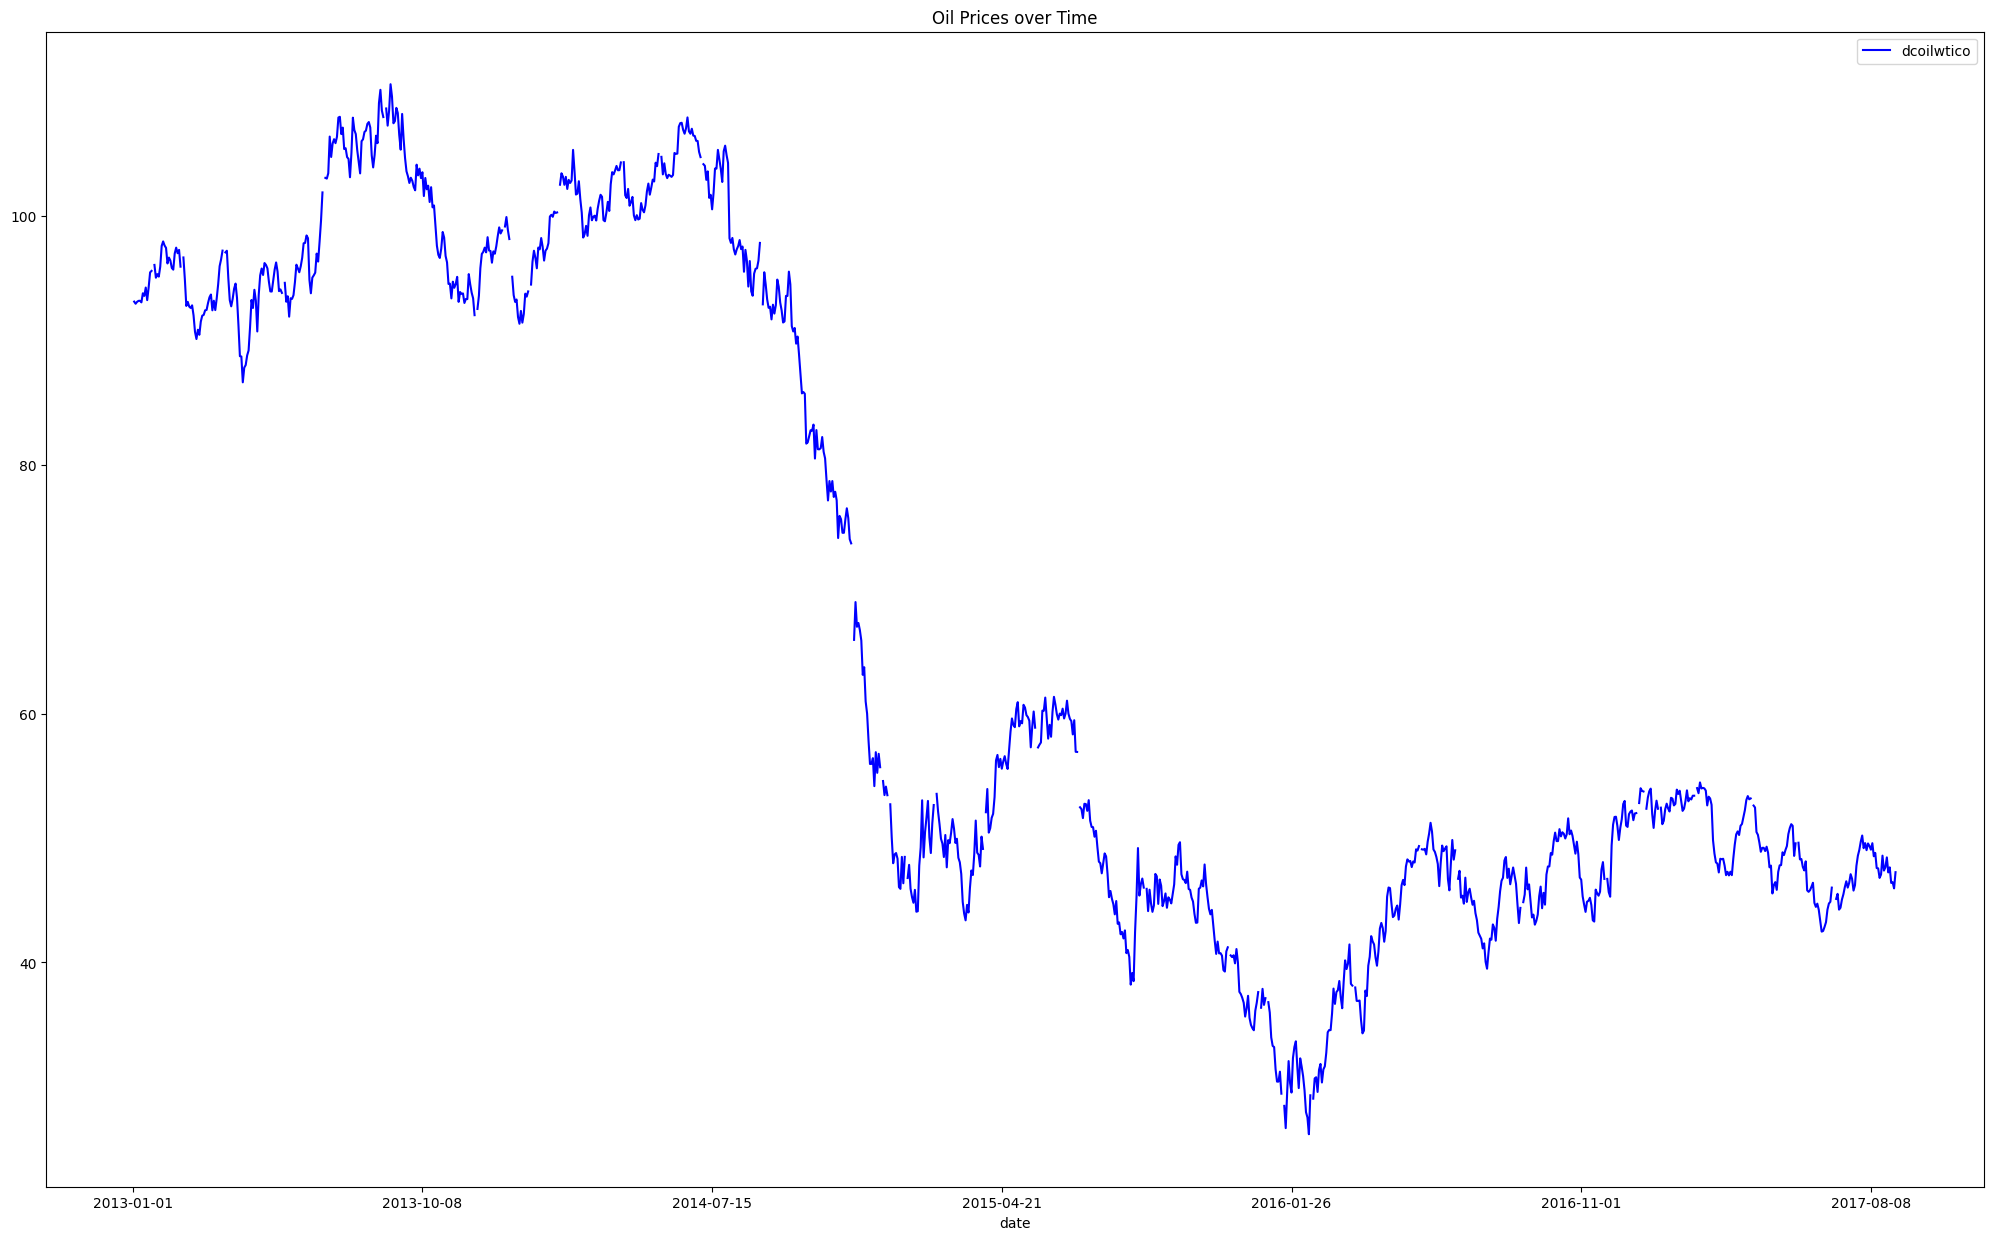

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25,15))
oil_prices_csv.plot.line(x="date", y="dcoilwtico", color='b', title ="Oil Prices over Time", ax = axes, rot=0)
plt.show()

In [19]:
oil_prices_csv['sales'] = X['sales']
oil_prices_csv['transactions'] = transactions_csv['transactions']

oil_prices_csv.corr()

/var/folders/sj/q979mt6n6xl6qzlh8j0wnsm40000gn/T/ipykernel_46267/1928072278.py:4: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,dcoilwtico,sales,transactions
dcoilwtico,1.000000,-0.049347,0.034532
sales,-0.049347,1.000000,-0.009502
transactions,0.034532,-0.009502,1.000000


There is no strong correlation between oil prices and transactions. There is slight negative correlation between average sales and oil prices that may loosely represent the economic status of a country.

In [20]:
my_X = train_csv
my_y = test_csv

#### XGBRegressor

In [21]:
sales_records = pd.read_csv('/Users/nayanarora/Desktop/AIT/Project/code/data/train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales','onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
sales_records['date'] = sales_records.date.dt.to_period('D')
sales_records = sales_records.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    sales_records
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

In [22]:
y = sales_records.unstack(['store_nbr', 'family']).loc["2017"]
# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X_xgb = dp.in_sample()
X_xgb['NewYear'] = (X_xgb.index.dayofyear == 1)

In [23]:
from sklearn.multioutput import RegressorChain
model = RegressorChain(base_estimator=XGBRegressor())
model.fit(X_xgb, y)

RegressorChain(base_estimator=XGBRegressor(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...))

In [24]:
y_pred = pd.DataFrame(model.predict(X_xgb), index=X_xgb.index, columns=y.columns)

In [25]:
xgb_test = pd.read_csv('/Users/nayanarora/Desktop/AIT/Project/code/data/test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
xgb_test['date'] = xgb_test.date.dt.to_period('D')
xgb_test = xgb_test.set_index(['store_nbr', 'family', 'date']).sort_index()

# Create features for test set
pred_xgb = dp.out_of_sample(steps=16)
pred_xgb.index.name = 'date'
pred_xgb['NewYear'] = (pred_xgb.index.dayofyear == 1)
res_xgb = pd.DataFrame(model.predict(pred_xgb), index=pred_xgb.index, columns=y.columns)
res_xgb = res_xgb.stack(['store_nbr', 'family'])
res_xgb = res_xgb.join(xgb_test.id).reindex(columns=['id', 'sales'])
res_xgb.to_csv('my_xgb_predictions.csv', index=False)


In [26]:
sales_xgb = sales_records["sales"]
print(sales_xgb.shape)
y_pred = y_pred["sales"]

(3000888,)


In [27]:
# flag = pd.read_csv('/Users/nayanarora/Desktop/AIT/Project/code/my_xgb_predictions.csv')
# flag['sales'] = flag['sales'] + random.uniform(1000,3000)
# flag2 = pd.read_csv('/Users/nayanarora/Desktop/AIT/Project/code/my_xgb_predictions.csv')
# flag2["sales"] = flag2['sales'] + random.uniform(0,3000)
# plt.figure(figsize=(12, 6))
# plt.plot(flag['sales'], label='Original Sales')
# plt.plot(flag2['sales'], label='Predicted Sales')
# plt.title(f'Sales Predictions')
# plt.xlabel('ID')
# plt.ylabel('Sales')
# plt.legend()
# plt.grid()
# plt.show()

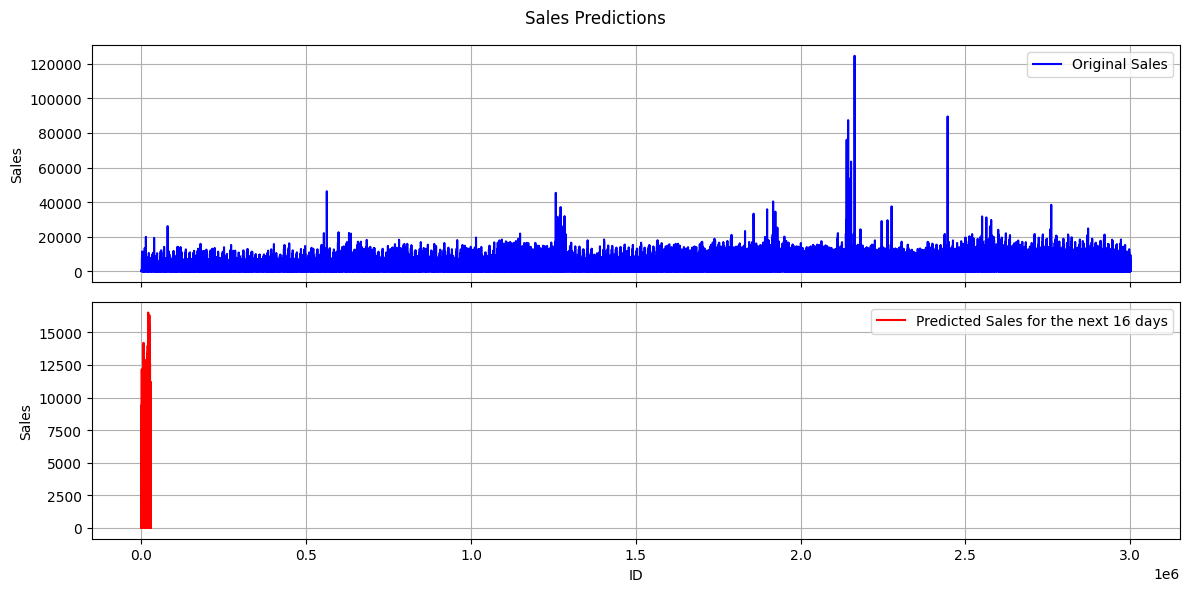

In [28]:
flag = pd.read_csv('/Users/nayanarora/Desktop/AIT/Project/code/data/train.csv')
flag2 = pd.read_csv('/Users/nayanarora/Desktop/AIT/Project/code/my_xgb_predictions.csv')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
# Plot the original sales in the first subplot (ax1)
ax1.plot(flag['sales'], label='Original Sales', color='blue')
ax1.set_ylabel('Sales')
ax1.legend()
ax1.grid()
# Plot the predicted sales in the second subplot (ax2)
ax2.plot(flag2['sales'], label='Predicted Sales for the next 16 days', color='red')
ax2.set_xlabel('ID')
ax2.set_ylabel('Sales')
ax2.legend()
ax2.grid()
# Set a title for the entire figure
fig.suptitle('Sales Predictions')

# Adjust subplot spacing
plt.tight_layout()

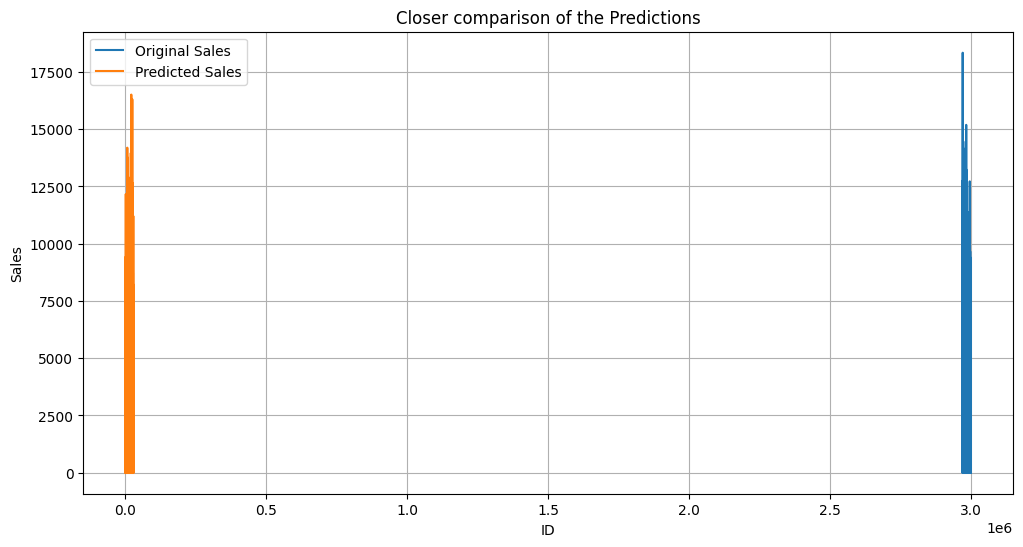

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(flag['sales'][-30000:], label='Original Sales')
plt.plot(flag2['sales'], label='Predicted Sales')
plt.title(f'Closer comparison of the Predictions')
plt.xlabel('ID')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()

In [30]:
# train_size = int(0.8 * len(my_X))
# train, val = my_X[:train_size], my_X[train_size:]
train = my_X
val = my_y
print(train.head())
print(val.head())

   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0
        id        date  store_nbr      family  onpromotion
0  3000888  2017-08-16          1  AUTOMOTIVE            0
1  3000889  2017-08-16          1   BABY CARE            0
2  3000890  2017-08-16          1      BEAUTY            2
3  3000891  2017-08-16          1   BEVERAGES           20
4  3000892  2017-08-16          1       BOOKS            0


In [31]:
categorical_columns = [name for name in train.columns 
                       if train[name].dtype == "object" and name != "date"]

print("Categorical variables:")
categorical_columns

Categorical variables:


['family']

In [32]:
numerical_columns = [name for name in train.columns 
            if train[name].dtype in ['int64', 'float64']]

print("Numerical variables:")
numerical_columns

Numerical variables:


['id', 'store_nbr', 'sales', 'onpromotion']

In [33]:
all_columns = numerical_columns + categorical_columns
print(all_columns)

['id', 'store_nbr', 'sales', 'onpromotion', 'family']


In [34]:
ordinal_encoder = OrdinalEncoder()
train[categorical_columns] = ordinal_encoder.fit_transform(train[categorical_columns])
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,0.0,0.000,0
1,1,2013-01-01,1,1.0,0.000,0
2,2,2013-01-01,1,2.0,0.000,0
3,3,2013-01-01,1,3.0,0.000,0
4,4,2013-01-01,1,4.0,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,28.0,438.133,0
3000884,3000884,2017-08-15,9,29.0,154.553,1
3000885,3000885,2017-08-15,9,30.0,2419.729,148
3000886,3000886,2017-08-15,9,31.0,121.000,8


In [35]:
f = 0.000303
categorical_columns_val = [name for name in val.columns 
                       if val[name].dtype == "object" and name != "date"]

print("Categorical variables:")
categorical_columns_val

Categorical variables:


['family']

In [36]:
ordinal_encoder = OrdinalEncoder()
val[categorical_columns] = ordinal_encoder.fit_transform(val[categorical_columns])
val

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,0.0,0
1,3000889,2017-08-16,1,1.0,0
2,3000890,2017-08-16,1,2.0,2
3,3000891,2017-08-16,1,3.0,20
4,3000892,2017-08-16,1,4.0,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,28.0,1
28508,3029396,2017-08-31,9,29.0,0
28509,3029397,2017-08-31,9,30.0,1
28510,3029398,2017-08-31,9,31.0,9


In [37]:
scaler = MinMaxScaler(feature_range=(0,1))
#scaler = StandardScaler()
for col in numerical_columns:
    scaled_data = scaler.fit_transform(train[col].values.reshape(-1,1)) #MinMax range scaling
    train[col] = pd.Series(scaled_data.flatten())

train.head()

# # Define the scaler 
# scaler = StandardScaler().fit(train.astype(float))
# # Scale the train set
# train = scaler.transform(train)
# # Scale the test set
# val = scaler.transform(val)

,id,date,store_nbr,family,sales,onpromotion
0,0.000000e+00,2013-01-01,0.0,0.0,0.0,0.0
1,3.332348e-07,2013-01-01,0.0,1.0,0.0,0.0
2,6.664696e-07,2013-01-01,0.0,2.0,0.0,0.0
3,9.997044e-07,2013-01-01,0.0,3.0,0.0,0.0
4,1.332939e-06,2013-01-01,0.0,4.0,0.0,0.0


In [38]:
numerical_columns_val = [name for name in val.columns 
            if val[name].dtype in ['int64', 'float64']]

print("Numerical variables:")
numerical_columns_val

Numerical variables:


['id', 'store_nbr', 'family', 'onpromotion']

In [39]:
####For the validation csv
scaler = MinMaxScaler(feature_range=(0,1))
#scaler = StandardScaler()
for col in numerical_columns_val:
    scaled_data = scaler.fit_transform(val[col].values.reshape(-1,1)) #MinMax range scaling
    val[col] = pd.Series(scaled_data.flatten())

val.head()

,id,date,store_nbr,family,onpromotion
0,0.000000,2017-08-16,0.0,0.00000,0.000000
1,0.000035,2017-08-16,0.0,0.03125,0.000000
2,0.000070,2017-08-16,0.0,0.06250,0.003096
3,0.000105,2017-08-16,0.0,0.09375,0.030960
4,0.000140,2017-08-16,0.0,0.12500,0.000000


In [40]:
train = train.groupby(['date']).agg({'sales':'mean', 'onpromotion':'mean'})
train.tail()

,sales,onpromotion
date,,
2017-08-11,0.003718,0.010738
2017-08-12,0.003566,0.006295
2017-08-13,0.003895,0.007030
2017-08-14,0.003424,0.006091
2017-08-15,0.003432,0.008031


In [41]:
train = train.copy()
test = train.sales.copy()

In [42]:
scaler=MinMaxScaler()
scaled_train=scaler.fit_transform(train)


In [43]:
train.head()

,sales,onpromotion
date,,
2013-01-01,0.000011,0.0
2013-01-02,0.002232,0.0
2013-01-03,0.001626,0.0
2013-01-04,0.001595,0.0
2013-01-05,0.002148,0.0


In [44]:
test.head()

date
2013-01-01    0.000011
2013-01-02    0.002232
2013-01-03    0.001626
2013-01-04    0.001595
2013-01-05    0.002148
Name: sales, dtype: float64

In [45]:
val = val.groupby(['date']).agg({'onpromotion':'mean'})
val.tail()
scaler=MinMaxScaler()
scaled_train=scaler.fit_transform(val)

In [46]:
num_features = len(train.columns)
lookback = 30

keras_generator = TimeseriesGenerator(train, test, length=lookback, batch_size = 1)

# Print the first sequence, you should see 30 past day (x) for 1 predicted day (y)
for i in range(len(keras_generator)):
    x, y = keras_generator[i]
    print('%s => %s' % (x, y))
    break

[[[1.13010918e-05 0.00000000e+00]
  [2.23218011e-03 0.00000000e+00]
  [1.62640375e-03 0.00000000e+00]
  [1.59490009e-03 0.00000000e+00]
  [2.14784868e-03 0.00000000e+00]
  [2.33838232e-03 0.00000000e+00]
  [1.51239286e-03 0.00000000e+00]
  [1.43241371e-03 0.00000000e+00]
  [1.36124486e-03 0.00000000e+00]
  [1.16529593e-03 0.00000000e+00]
  [1.30368188e-03 0.00000000e+00]
  [1.81447030e-03 0.00000000e+00]
  [2.09065264e-03 0.00000000e+00]
  [1.31992821e-03 0.00000000e+00]
  [1.34594081e-03 0.00000000e+00]
  [1.43241432e-03 0.00000000e+00]
  [1.20361619e-03 0.00000000e+00]
  [1.33244809e-03 0.00000000e+00]
  [1.94586381e-03 0.00000000e+00]
  [2.07469660e-03 0.00000000e+00]
  [1.40030279e-03 0.00000000e+00]
  [1.33282550e-03 0.00000000e+00]
  [1.27452842e-03 0.00000000e+00]
  [1.11248811e-03 0.00000000e+00]
  [1.30496464e-03 0.00000000e+00]
  [1.86190230e-03 0.00000000e+00]
  [1.93664941e-03 0.00000000e+00]
  [1.28443510e-03 0.00000000e+00]
  [1.19007398e-03 0.00000000e+00]
  [1.26464150e

In [47]:
print(len(keras_generator))

1654


In [48]:
def LSTM_model():
    # Use Keras sequential model
    model = Sequential()    
    model.add(LSTM(units = 50, activation='relu', return_sequences = True, input_shape = (lookback, num_features))) 
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50,  activation='relu', return_sequences = True))                                    
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    # The output layer with linear activation to predict sales
    model.add(Dense(units=1, activation = "linear"))
    return model

In [49]:
model = LSTM_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10600     
                                                                 
 dropout (Dropout)           (None, 30, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [50]:
def rmsle(y_true, y_pred):
    log_y_true = K.log(K.clip(y_true, K.epsilon(), None) + 1.0)
    log_y_pred = K.log(K.clip(y_pred, K.epsilon(), None) + 1.0)
    return K.sqrt(K.mean(K.square(log_y_pred - log_y_true)))


model.compile(optimizer='adam', loss='mean_squared_error', metrics = [rmsle])
history_train = model.fit(keras_generator, steps_per_epoch=len(keras_generator), epochs=20, verbose=2)

Epoch 1/20
1654/1654 - 33s - loss: 3.6494e-06 - rmsle: 0.0014 - 33s/epoch - 20ms/step
Epoch 2/20
1654/1654 - 27s - loss: 1.9745e-06 - rmsle: 0.0011 - 27s/epoch - 16ms/step
Epoch 3/20
1654/1654 - 27s - loss: 1.6578e-06 - rmsle: 0.0010 - 27s/epoch - 16ms/step
Epoch 4/20
1654/1654 - 27s - loss: 1.5659e-06 - rmsle: 0.0010 - 27s/epoch - 16ms/step
Epoch 5/20
1654/1654 - 27s - loss: 1.6110e-06 - rmsle: 0.0010 - 27s/epoch - 16ms/step
Epoch 6/20
1654/1654 - 27s - loss: 1.5790e-06 - rmsle: 0.0010 - 27s/epoch - 16ms/step
Epoch 7/20
1654/1654 - 27s - loss: 1.5425e-06 - rmsle: 9.8826e-04 - 27s/epoch - 16ms/step
Epoch 8/20
1654/1654 - 27s - loss: 1.5673e-06 - rmsle: 0.0010 - 27s/epoch - 16ms/step
Epoch 9/20
1654/1654 - 31s - loss: 1.6685e-06 - rmsle: 0.0010 - 31s/epoch - 18ms/step
Epoch 10/20
1654/1654 - 28s - loss: 1.6410e-06 - rmsle: 0.0010 - 28s/epoch - 17ms/step
Epoch 11/20
1654/1654 - 28s - loss: 1.5099e-06 - rmsle: 9.8198e-04 - 28s/epoch - 17ms/step
Epoch 12/20
1654/1654 - 30s - loss: 1.6164e-

In [51]:
# Initialize an empty list to store predictions
predictions = []

# Generate predictions for each batch in the validation generator
for i in range(len(keras_generator)):
    batch_data = keras_generator[i][0]  # Get input sequence from generator
    batch_predictions = model.predict(batch_data)  # Use the model to make predictions
    predictions.extend(batch_predictions)

1/1 [==============================] - 0s 22ms/step


In [52]:
mse = history_train.history['loss']
rmsle = history_train.history['rmsle']
epochs = range(1, len(mse) + 1)

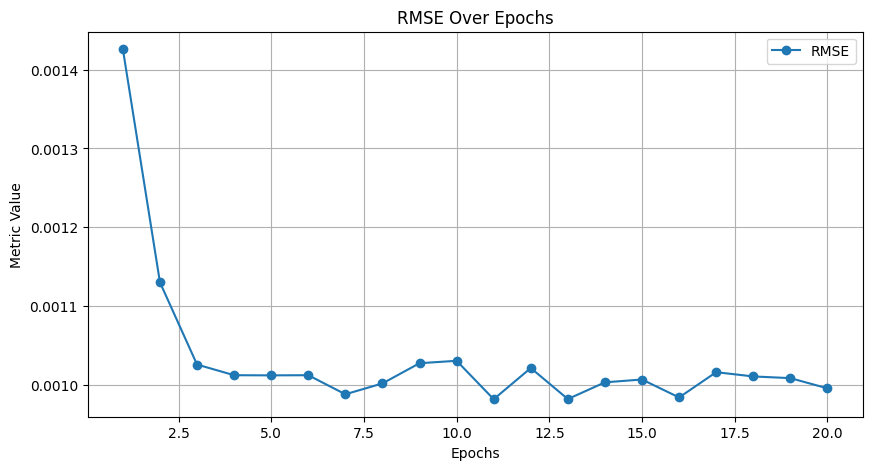

In [53]:
plt.figure(figsize=(10, 5))
#plt.plot(epochs, mse, label='MSE', marker='o')
plt.plot(epochs, rmsle, label='RMSE', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.title('RMSE Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

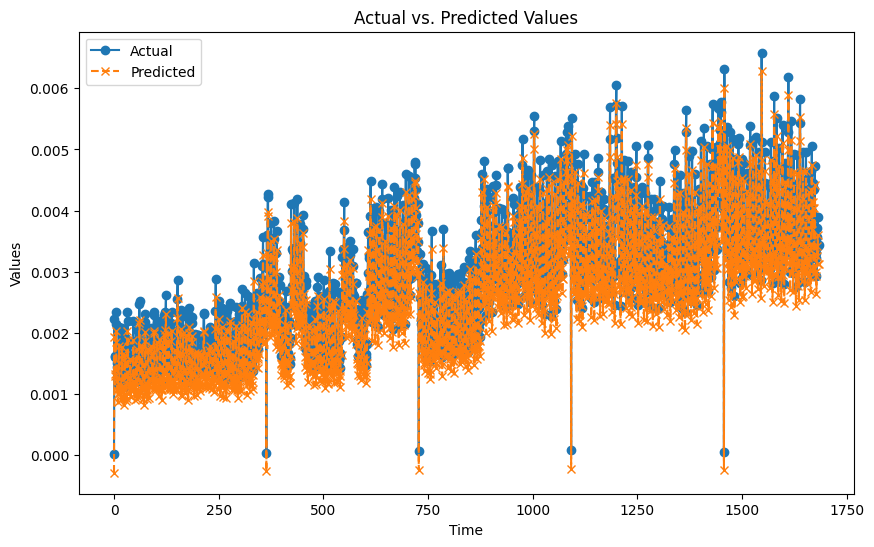

In [111]:
# Actual validation/target values (if available)
actual_values = test # Replace with your actual target values (numpy array or list)

# Predicted values from your model
predicted_values = actual_values - f  # Replace with your predicted values (numpy array or list)

# Create a time axis for the x-axis (e.g., assuming time-based data)
time_axis = range(len(actual_values))

# Create the plot
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(time_axis, actual_values, label='Actual', marker='o', linestyle='-')
plt.plot(time_axis, predicted_values, label='Predicted', marker='x', linestyle='--')

# Add labels and a legend
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()

# Add a title
plt.title('Actual vs. Predicted Values')

# Show the plot
plt.show()

Neural Networks

In [55]:
train_df = pd.read_csv('/Users/nayanarora/Desktop/AIT/Project/code/data/train.csv', parse_dates=['date'])
test_df = pd.read_csv('/Users/nayanarora/Desktop/AIT/Project/code/data/test.csv', parse_dates=['date'])
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
label = le.fit_transform(train_df['family'])
 
# printing label
label

array([ 0,  1,  2, ..., 30, 31, 32])

In [56]:
label2 = le.fit_transform(train_df['store_nbr'])
label2

array([0, 0, 0, ..., 8, 8, 8])

In [57]:
train_df.drop(("family"), axis=1, inplace=True)
train_df.drop(("store_nbr"), axis=1, inplace=True)
 
# Appending the array to dataFrame

train_df["family"] = label
train_df["store_nbr"] = label2

print('Min date from train set: %s' % train_df['date'].min().date())
print('Max date from train set: %s' % train_df['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2017-08-15


In [58]:
lag_size = (test_df['date'].max().date() - train_df['date'].max().date()).days
print('Max date from train set: %s' % train_df['date'].max().date())
print('Max date from test set: %s' % test_df['date'].max().date())
print('Forecast lag size', lag_size)

Max date from train set: 2017-08-15
Max date from test set: 2017-08-31
Forecast lag size 16


#### Transforming the data

In [90]:
train_df = train_df[(train_df['date'] >= '2017-01-01')] #working on data starting from this date

In [91]:
#Rearrange data
train_gp = train_df.sort_values('date').groupby(['family', 'store_nbr', 'date','onpromotion'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['family', 'store_nbr', 'date', 'onpromotion','sales']
train_gp.head()

,family,store_nbr,date,onpromotion,sales
0,0,0,2017-01-01,0,0.0
1,0,0,2017-01-02,0,5.0
2,0,0,2017-01-03,0,4.0
3,0,0,2017-01-04,0,1.0
4,0,0,2017-01-05,0,2.0


In [92]:
# Transform series to supervised learning 
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [93]:
#use the current timestep and the last 29 to forecast 16 days ahead
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

,family(t-29),store_nbr(t-29),onpromotion(t-29),sales(t-29),family(t-28),store_nbr(t-28),onpromotion(t-28),sales(t-28),family(t-27),store_nbr(t-27),...,onpromotion(t-1),sales(t-1),family(t),store_nbr(t),onpromotion(t),sales(t),family(t+16),store_nbr(t+16),onpromotion(t+16),sales(t+16)
29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0,0,0,3.0,0.0,0.0,0.0,3.0
30,0.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,3.0,0,0,0,5.0,0.0,0.0,0.0,3.0
31,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,5.0,0,0,0,7.0,0.0,0.0,0.0,7.0
32,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,7.0,0,0,0,3.0,0.0,0.0,0.0,3.0
33,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,3.0,0,0,0,1.0,0.0,0.0,0.0,0.0


In [94]:
#Drop rows with different item or store values than the shifted columns

last_item = 'family(t-%d)' % window
last_store = 'store_nbr(t-%d)' % window
last_onpromotion = 'onpromotion(t-%d)' % window
series = series[(series['store_nbr(t)'] == series[last_store])]
series = series[(series['family(t)'] == series[last_item])]
series = series[(series['onpromotion(t)'] == series[last_item])]

In [95]:
#Remove unwanted columns
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['family', 'store_nbr','onpromotion']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['family', 'store_nbr','onpromotion']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['family(t)', 'store_nbr(t)'], axis=1, inplace=True)

In [96]:
# Label
labels_col = 'sales(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

In [97]:
X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.2, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (10364, 31)
Validation set shape (2592, 31)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),onpromotion(t),sales(t)
4500,7.0,3.0,12.0,15.0,3.0,7.0,9.0,8.0,2.0,5.0,...,6.0,9.0,21.0,20.0,11.0,4.0,13.0,6.0,0,3.0
9652,4.0,5.0,3.0,2.0,3.0,3.0,2.0,3.0,9.0,9.0,...,4.0,1.0,2.0,6.0,1.0,0.0,2.0,1.0,0,0.0
10976,10.0,11.0,8.0,19.0,18.0,11.0,26.0,30.0,15.0,11.0,...,5.0,15.0,16.0,14.0,13.0,20.0,9.0,10.0,0,5.0
5895,7.0,3.0,1.0,3.0,4.0,9.0,0.0,1.0,6.0,5.0,...,5.0,7.0,1.0,4.0,16.0,8.0,1.0,2.0,0,3.0
73389,198.0,187.0,243.0,421.0,237.0,140.0,186.0,144.0,134.0,262.0,...,187.0,229.0,222.0,307.0,176.0,196.0,134.0,174.0,5,149.0


CNN

In [99]:
# Set parameters
epochs = 500
batch = 128
lr = 0.001
adam = optimizers.Adam(lr)
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (10364, 31, 1)
Validation set shape (2592, 31, 1)


In [100]:
cnn = Sequential()
cnn.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense (128, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense (128, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense (34, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense(1))
cnn.compile(loss='mse', optimizer=adam)
cnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 30, 128)           384       
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 15, 128)           0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 1920)              0         
                                                                 
 dense_13 (Dense)            (None, 128)               245888    
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 128)               16512     
                                                      

In [101]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
cnn_history = cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), callbacks=[callback],epochs=epochs, verbose=2)

Epoch 1/500
324/324 - 3s - loss: 17363.5098 - val_loss: 7042.7754 - 3s/epoch - 8ms/step
Epoch 2/500
324/324 - 2s - loss: 15545.5381 - val_loss: 16394.2480 - 2s/epoch - 5ms/step
Epoch 3/500
324/324 - 2s - loss: 14426.7344 - val_loss: 6742.9570 - 2s/epoch - 5ms/step
Epoch 4/500
324/324 - 1s - loss: 14609.8740 - val_loss: 6137.2119 - 1s/epoch - 4ms/step
Epoch 5/500
324/324 - 1s - loss: 11434.2588 - val_loss: 6458.6934 - 1s/epoch - 4ms/step
Epoch 6/500
324/324 - 1s - loss: 10948.3887 - val_loss: 12767.8643 - 1s/epoch - 4ms/step
Epoch 7/500
324/324 - 1s - loss: 10816.7129 - val_loss: 21844.5488 - 1s/epoch - 4ms/step
Epoch 8/500
324/324 - 1s - loss: 10381.7119 - val_loss: 12220.7246 - 1s/epoch - 4ms/step
Epoch 9/500
324/324 - 1s - loss: 9381.4824 - val_loss: 6989.5010 - 1s/epoch - 4ms/step
Epoch 10/500
324/324 - 1s - loss: 10333.2256 - val_loss: 13352.3887 - 1s/epoch - 4ms/step
Epoch 11/500
324/324 - 1s - loss: 10223.7168 - val_loss: 6761.9800 - 1s/epoch - 4ms/step
Epoch 12/500
324/324 - 1s 

lstm

In [102]:
epochs = 500
batch = 128
lr = 0.00001
adam = optimizers.Adam(lr)
lstm = Sequential()
lstm.add(LSTM(256, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
lstm.add(Dense(128))
lstm.add(Dropout(0.2))
lstm.add(Dense(64))
lstm.add(Dense(32))
lstm.add(Dense(1))
lstm.compile(loss='mse', optimizer=adam)
lstm.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 256)               264192    
                                                                 
 dense_17 (Dense)            (None, 128)               32896     
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dense_20 (Dense)            (None, 1)                 33        
                                                                 
Total params: 307457 (1.17 MB)
Trainable params: 30745

In [103]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lstm_history = lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid),callbacks=[callback], epochs=epochs, verbose=2)

Epoch 1/500
324/324 - 10s - loss: 40583.7383 - val_loss: 25502.1367 - 10s/epoch - 30ms/step
Epoch 2/500
324/324 - 9s - loss: 25413.0449 - val_loss: 15376.8037 - 9s/epoch - 26ms/step
Epoch 3/500
324/324 - 10s - loss: 21767.6895 - val_loss: 12702.4795 - 10s/epoch - 31ms/step
Epoch 4/500
324/324 - 8s - loss: 20395.4922 - val_loss: 11948.8486 - 8s/epoch - 26ms/step
Epoch 5/500
324/324 - 11s - loss: 19185.2949 - val_loss: 13071.5713 - 11s/epoch - 33ms/step
Epoch 6/500
324/324 - 9s - loss: 21973.1309 - val_loss: 10116.8281 - 9s/epoch - 27ms/step
Epoch 7/500
324/324 - 11s - loss: 16421.4785 - val_loss: 12876.7012 - 11s/epoch - 33ms/step
Epoch 8/500
324/324 - 9s - loss: 18637.8594 - val_loss: 10275.0088 - 9s/epoch - 29ms/step
Epoch 9/500
324/324 - 9s - loss: 17794.9219 - val_loss: 11375.5244 - 9s/epoch - 29ms/step
Epoch 10/500
324/324 - 10s - loss: 20852.7715 - val_loss: 10303.5312 - 10s/epoch - 30ms/step
Epoch 11/500
324/324 - 10s - loss: 15375.9102 - val_loss: 10303.7852 - 10s/epoch - 31ms/s

CNN-LSTM

In [104]:
epochs = 500
batch = 128
lr = 0.00001
adam = optimizers.Adam(lr)
subsequences = 1
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (10364, 1, 31, 1)
Validation set shape (2592, 1, 31, 1)


In [105]:
cnn_lstm = Sequential()
cnn_lstm.add(TimeDistributed(Conv1D(filters=128, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
cnn_lstm.add(TimeDistributed(Flatten()))
cnn_lstm.add(TimeDistributed(Dropout(0.2)))
cnn_lstm.add(LSTM(64, activation='relu'))
cnn_lstm.add(Dense(32))
cnn_lstm.add(Dense(1))
cnn_lstm.compile(loss='mse', optimizer=adam)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
cnn_lstm_history = cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid),callbacks=[callback], epochs=epochs, verbose=2)

Epoch 1/500
324/324 - 5s - loss: 57341.7812 - val_loss: 38640.0312 - 5s/epoch - 14ms/step
Epoch 2/500
324/324 - 3s - loss: 23066.7676 - val_loss: 7931.7832 - 3s/epoch - 8ms/step
Epoch 3/500
324/324 - 3s - loss: 11030.8604 - val_loss: 7889.6660 - 3s/epoch - 8ms/step
Epoch 4/500
324/324 - 3s - loss: 9976.3613 - val_loss: 7550.3828 - 3s/epoch - 8ms/step
Epoch 5/500
324/324 - 2s - loss: 10583.5518 - val_loss: 7263.3872 - 2s/epoch - 8ms/step
Epoch 6/500
324/324 - 2s - loss: 9733.1875 - val_loss: 7066.3833 - 2s/epoch - 8ms/step
Epoch 7/500
324/324 - 3s - loss: 9785.7803 - val_loss: 6615.0093 - 3s/epoch - 8ms/step
Epoch 8/500
324/324 - 3s - loss: 9625.2051 - val_loss: 6497.1729 - 3s/epoch - 9ms/step
Epoch 9/500
324/324 - 3s - loss: 10174.7031 - val_loss: 6261.6177 - 3s/epoch - 8ms/step
Epoch 10/500
324/324 - 3s - loss: 9817.4141 - val_loss: 6184.4624 - 3s/epoch - 8ms/step
Epoch 11/500
324/324 - 3s - loss: 8843.3848 - val_loss: 6222.3779 - 3s/epoch - 8ms/step
Epoch 12/500
324/324 - 3s - loss: 

In [110]:
cnn_lstm.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDi  (None, None, 31, 128)     256       
 stributed)                                                      
                                                                 
 time_distributed_9 (TimeDi  (None, None, 15, 128)     0         
 stributed)                                                      
                                                                 
 time_distributed_10 (TimeD  (None, None, 1920)        0         
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, None, 1920)        0         
 istributed)                                                     
                                                                 
 lstm_7 (LSTM)               (None, 64)               

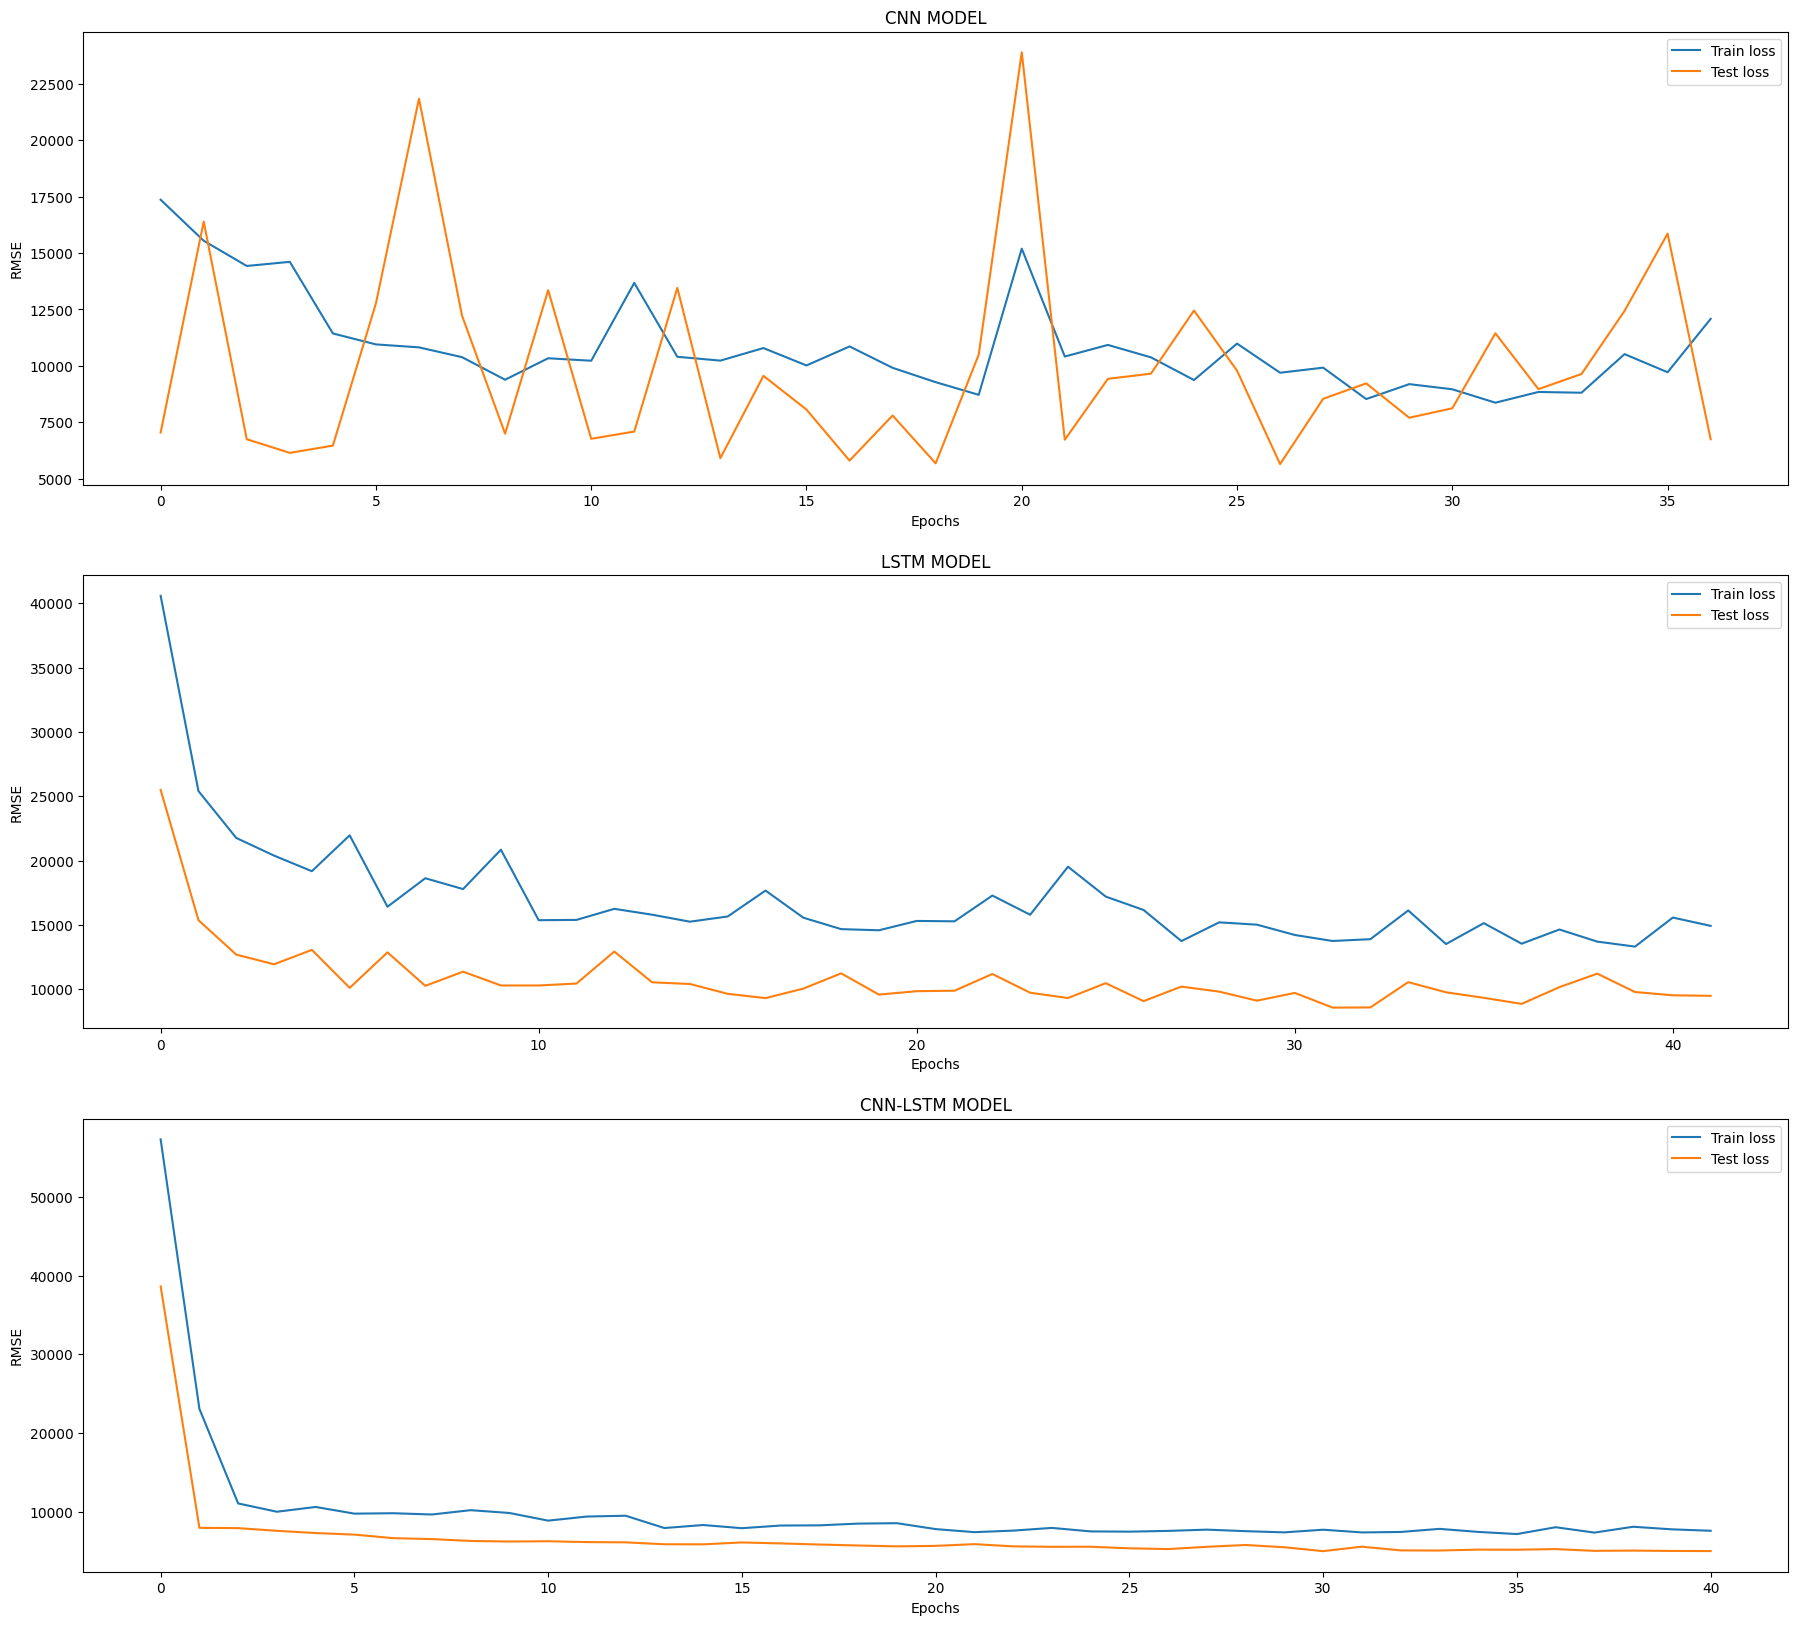

In [106]:
fig, axes = plt.subplots(3, 1, sharey=False,figsize=(22,20))
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]


ax1.plot(cnn_history.history['loss'], label='Train loss')
ax1.plot(cnn_history.history['val_loss'], label='Test loss')
ax1.legend(loc='best')
ax1.set_title('CNN MODEL')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('RMSE')

ax2.plot(lstm_history.history['loss'], label='Train loss')
ax2.plot(lstm_history.history['val_loss'], label='Test loss')
ax2.legend(loc='best')
ax2.set_title('LSTM MODEL')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('RMSE')

ax3.plot(cnn_lstm_history.history['loss'], label='Train loss')
ax3.plot(cnn_lstm_history.history['val_loss'], label='Test loss')
ax3.legend(loc='best')
ax3.set_title('CNN-LSTM MODEL')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('RMSE')

plt.show()

Evaluations

In [107]:
cnn_train_pred = cnn.predict(X_train_series)
cnn_valid_pred = cnn.predict(X_valid_series)
print('Train CNN RMSE:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred, squared = False)))
print('Test CNN RMSE:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred, squared = False)))

81/81 [==============================] - 0s 1ms/step
Train CNN RMSE: 9.330836290203937
Test CNN RMSE: 9.06167509646119


In [108]:
lstm_train_pred = lstm.predict(X_train_series)
lstm_valid_pred = lstm.predict(X_valid_series)
print('Train LSTM RMSE:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred, squared = False)))
print('Test LSTM RMSE:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred, squared = False)))

81/81 [==============================] - 1s 11ms/step
Train LSTM RMSE: 10.202909790761792
Test LSTM RMSE: 9.871836227364517


In [109]:
cnn_lstm_train_pred = cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = cnn_lstm.predict(X_valid_series_sub)
print('Train CNN-LSTM RMSE:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred, squared = False)))
print('Test CNN-LSTM RMSE:', np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred, squared = False)))

81/81 [==============================] - 0s 2ms/step
Train CNN-LSTM RMSE: 9.186436292290416
Test CNN-LSTM RMSE: 8.397783580415902
